In [19]:
import pandas as pd
import numpy as np
from data_tools.api import *
from utilscht import *
from joblib import Parallel,delayed

In [3]:
date_ls=get_trade_dates(20190201,20191206)

cross_top30_trend_tail40_stkpool_dict={}
for date in date_ls:
    cross_df=pd.read_excel(r"/share/intern_share/stk_bundle/crosscount_summary_{}.xlsx".format(date))
    trend_df=pd.read_csv(r"/home/ywang/proj_cross_grid/data/task1/task1_{}.csv".format(date))
    
    cross_df=cross_df.sort_values("20d_count",ascending=False).reset_index(drop=True)
    trend_df=trend_df.sort_values("ret",ascending=True).reset_index(drop=True)
    
    cross_top_30p_stkpool=np.array(cross_df["sid"])[0:int(0.1*len(cross_df.index))]
    trend_tail_40p_stkpool=np.array(trend_df["sid"])[0:int(0.3*np.sum(trend_df["isin_pool"]))]
    
    cross_top30_trend_tail40_stkpool_dict[date]=set(cross_top_30p_stkpool)&set(trend_tail_40p_stkpool)


In [ ]:
file=open(r"data/cross_top30_trend_tail40_stkpool.txt","w")
for k,v in cross_top30_trend_tail40_stkpool_dict.items():
    file.write(str(k)+":\n"+"  ".join(list(v)))
    file.write("\n\n")
file.close()

In [20]:
date_ls=get_trade_dates(20190201,20191206)

cross_top30_trend_tail40_stkpool_df=pd.DataFrame()
for date in date_ls:
    cross_df=pd.read_excel(r"/share/intern_share/stk_bundle/crosscount_summary_{}.xlsx".format(date))
    trend_df=pd.read_csv(r"/home/ywang/proj_cross_grid/data/task1/task1_{}.csv".format(date))
    
    cross_df=cross_df.sort_values("20d_count",ascending=False).reset_index(drop=True)
    trend_df=trend_df.sort_values("ret",ascending=True).reset_index(drop=True)
    
    cross_top_30p_stkpool=np.array(cross_df["sid"])[0:int(0.05*len(cross_df.index))]
    trend_tail_40p_stkpool=np.array(trend_df["sid"])[0:int(0.3*np.sum(trend_df["isin_pool"]))]
    
    temp_df=pd.DataFrame(index=set(cross_top_30p_stkpool)&set(trend_tail_40p_stkpool))
    temp_df["DataDate"]=date
    cross_top30_trend_tail40_stkpool_df=pd.concat([cross_top30_trend_tail40_stkpool_df,temp_df])

In [21]:
cross_top30_trend_tail40_stkpool_df=cross_top30_trend_tail40_stkpool_df.reset_index().rename(columns={"index":"sid"})
cross_top30_trend_tail40_stkpool_df.to_excel(r"result/cross_top5_trend_tail30_stkpool_to20191206.xlsx")

In [22]:
#相同股票连续出现只取第一天
cross_top30_trend_tail40_stkpool_df=cross_top30_trend_tail40_stkpool_df.sort_values(["sid","DataDate"])
cross_top30_trend_tail40_stkpool_df["DateIndex"]=cross_top30_trend_tail40_stkpool_df["DataDate"].apply(lambda x:date_ls.index(x))
sub_df_1=cross_top30_trend_tail40_stkpool_df.groupby("sid").apply(lambda x:x.loc[(x["DateIndex"]-x["DateIndex"].shift(1))>1])
sub_df_2=cross_top30_trend_tail40_stkpool_df.groupby("sid").apply(lambda x:x.loc[x.index[0]])
cross_top30_trend_tail40_stkpool_df=pd.concat([sub_df_1,sub_df_2]).sort_values(["sid","DataDate"])
cross_top30_trend_tail40_stkpool_df.drop_duplicates(("sid","DataDate"),inplace=True)
cross_top30_trend_tail40_stkpool_df.reset_index(drop=True,inplace=True)

In [26]:
#寻找每只股票每天在将来出现10d_ret跑输hs300、cs500的日期
def apply_parallel(df_grouped, func, n_jobs=16, backend='loky', as_index=False, **kwargs):
    """
    This is for parallel between grouped generated by pd.DataFrame.groupby
    :param df_grouped:
    :param func:
    :param n_jobs:
    :param backend:
    :param kwargs:
    :return:
    """

    names = []
    groups = []
    for name, group in df_grouped:
        names.append(name)
        groups.append(group)

    results = Parallel(n_jobs=n_jobs,verbose=5,backend=backend, batch_size='auto')\
                      (delayed(func)(group, **kwargs) for group in groups)

    return pd.concat(results, keys=names if as_index else None)



date_ls=get_trade_dates(20190201,20191206)

result_df=pd.DataFrame()
def Find_First_Date(daily_df):
    daily_df.set_index("sid",inplace=True)
    
    daily_df["Date_hs300"]=np.nan
    daily_df["Date_cs500"]=np.nan
    
    stk_pool_1=set(daily_df.index)
    stk_pool_2=set(daily_df.index)
    
    date=daily_df.DataDate[daily_df.index[0]]

    for future_date in date_ls[date_ls.index(date)+1:]:
        if len(stk_pool_1)==0 & len(stk_pool_2)==0:
            break
        
        stk_sub_idx_ret=pd.read_csv(r"data/task2_v2/task2_v2_{}.csv".format(future_date))
        
        stk_ls=stk_sub_idx_ret["sid"][stk_sub_idx_ret["ret_10d_hs300"]<-0.10]
        stk_ls=set(stk_ls)&stk_pool_1
        stk_pool_1=stk_pool_1-stk_ls
        daily_df.loc[stk_ls,"Date_hs300"]=future_date
        
        stk_ls=stk_sub_idx_ret["sid"][stk_sub_idx_ret["ret_10d_cs500"]<-0.10]
        stk_ls=set(stk_ls)&stk_pool_2
        stk_pool_2=stk_pool_2-stk_ls
        daily_df.loc[stk_ls,"Date_cs500"]=future_date
    
    daily_df.reset_index(inplace=True)
    return daily_df

result_df=cross_top30_trend_tail40_stkpool_df.groupby("DataDate").apply(Find_First_Date)

In [27]:
#对于同一出现天数，
hs300_result=result_df[["sid","DataDate","Date_hs300"]].drop_duplicates(("sid","Date_hs300"),keep="last").dropna().reset_index(drop=True)
cs500_result=result_df[["sid","DataDate","Date_cs500"]].drop_duplicates(("sid","Date_cs500"),keep="last").dropna().reset_index(drop=True)

In [28]:
hs300_result.to_excel(r"result/hs300_result_10d_10p_to20191206.xlsx")
cs500_result.to_excel(r"result/cs500_result_10d_10p_to20191206.xlsx")

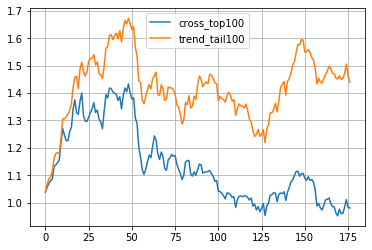

In [74]:
# cross_trend 选股回测
import matplotlib.pyplot as plt

portfolio_ret_series_cross=pd.Series(index=date_ls)
portfolio_ret_series_trend=pd.Series(index=date_ls)

for date in date_ls[1:-1]:
    print(date,end="\r")
    today_df=query_table("DailyBar",start_date=date,end_date=date,fields=["tradable","adj_open"])
    today_df=today_df[today_df["tradable"]==1]
    next_date=date_ls[date_ls.index(date)+1]
    next_date_df=query_table("DailyBar",start_date=next_date,end_date=next_date,fields=["tradable","adj_open"])
    next_date_df=next_date_df[next_date_df["tradable"]==1]

    merged_df=pd.merge(today_df,next_date_df,on="sid")
    merged_df["change_rate"]=merged_df["adj_open_y"]/merged_df["adj_open_x"]-1
    merged_df.set_index("sid",inplace=True)
    
    pre_date=date_ls[date_ls.index(date)-1]
    cross_df=pd.read_excel(r"/share/intern_share/stk_bundle/crosscount_summary_{}.xlsx".format(pre_date))
    trend_df=pd.read_csv(r"/home/ywang/data/task1/task1_{}.csv".format(pre_date))
    cross_df=cross_df.sort_values("20d_count",ascending=False).reset_index(drop=True)
    trend_df=trend_df.sort_values("ret",ascending=True).reset_index(drop=True)
    stock_pool_cross=np.array(cross_df["sid"][0:100])
    stock_pool_trend=np.array(trend_df["sid"][0:100])
    
    
    portfolio_ret_cross=np.mean(np.array(merged_df.loc[stock_pool_cross,"change_rate"].dropna()))
    portfolio_ret_series_cross[date]=portfolio_ret_cross
    portfolio_ret_trend=np.mean(np.array(merged_df.loc[stock_pool_trend,"change_rate"].dropna()))
    portfolio_ret_series_trend[date]=portfolio_ret_trend

cum_ret_cross=np.cumprod(1+np.array(portfolio_ret_series_cross[1:-1]))
plt.plot(cum_ret_cross,label="cross_top100")

cum_ret_trend=np.cumprod(1+np.array(portfolio_ret_series_trend[1:-1]))
plt.plot(cum_ret_trend,label="trend_tail100")

plt.grid()
plt.legend()